In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# project modules
import os
import sys
import re
sys.path.insert(0, os.path.abspath('../../modules'))

import helper_functions as hf


### Read the data

In [3]:

balanced_dataset = '/../../data/training/ber-rating-dataset-final.csv' # balanced dataset
current_folder = os.path.abspath('.')

df = pd.read_table(current_folder + balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

# replace any spurious characters in feature names
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))
# replace spaces in features names
df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)

print(df.shape)

df.head()



C:\Users\jbyrne\AppData\Local\Temp\ipykernel_11856\3240520560.py:4: DtypeWarning: Columns (143,146,147,153,154,157) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(current_folder + balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")


(110506, 212)


,index,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorAreasqm,UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,9279,Dublin 9,Ground-floor apartment,1900,Existing,D1,247.81,20.48,0.36,0.20,...,NaN,NaN,268029003,0.05,0.05,0.000,5075.22,0.0,0.505,0.749
1,7829,Co. Cavan,Detached house,2005,Existing,A1,21.97,169.28,0.37,0.15,...,NaN,NaN,27024011,0.05,0.05,0.811,3719.51,16005.0,0.092,0.147
2,1238,Co. Cork,Detached house,1967,Existing,E1,325.88,139.93,0.83,1.22,...,5.0,10.0,047191001,0.05,0.05,0.000,44563.50,0.0,2.428,2.037
3,3163,Co. Limerick,Detached house,1900,Existing,E1,303.37,183.05,0.74,2.30,...,NaN,NaN,127020003,0.05,0.05,0.000,54952.40,0.0,2.626,2.147
4,12834,Co. Limerick,Detached house,1984,Existing,D2,278.53,124.86,0.60,0.20,...,NaN,NaN,127069001,0.05,0.05,0.000,34204.90,0.0,2.040,1.715


In [4]:
df['EnergyRating'].value_counts()
#df.loc[df['EnergyRating'] == "A2"]

EnergyRating
G     7412
D1    7408
D2    7408
F     7399
C3    7391
E2    7382
C1    7379
B1    7374
E1    7370
A3    7370
C2    7367
B3    7355
A2    7335
B2    7297
A1    7259
Name: count, dtype: int64

<Axes: ylabel='count'>

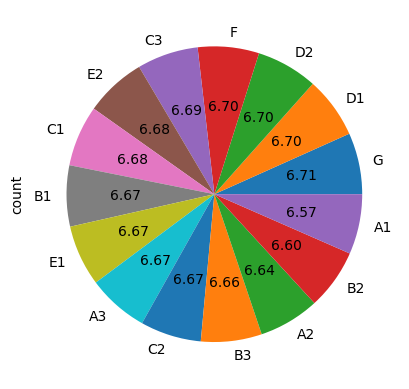

In [5]:
# check data to see if it is balanced
df['EnergyRating'].value_counts().plot.pie(autopct='%.2f')
#df.info(verbose=True, show_counts=True)

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['BerRating', 'EnergyRating'], axis='columns')
y_energy_rating = df[['EnergyRating']] # dependent variable
y_ber_rating = df[['BerRating']] 

X_train, X_test, y_energy_rating_train, y_energy_rating_test, y_ber_rating_train, y_ber_rating_test = train_test_split( X, y_energy_rating, y_ber_rating, test_size=0.2, shuffle=True,random_state=20)

X_train.shape, X_test.shape, y_energy_rating_train.shape, y_energy_rating_test.shape, y_ber_rating_train.shape, y_ber_rating_test.shape


((88404, 210), (22102, 210), (88404, 1), (22102, 1), (88404, 1), (22102, 1))

In [7]:

# balance training data
X_train_merged = pd.concat([X_train, y_energy_rating_train], axis='columns')

X_train_res_merged, y_energy_rating_train_balanced = hf.feature_balance_data(X_train_merged, y_energy_rating_train)
X_train_balanced = X_train_res_merged.drop('EnergyRating', axis='columns')
y_energy_rating_train_balanced_2 = X_train_res_merged[['EnergyRating']]

# outputs - the total rows should be the same
[X_train_balanced.shape, y_energy_rating_train_balanced.shape, y_energy_rating_train_balanced_2.shape]

#print(type(X_train_merged))

all_vals: <class 'list'>
15
target_stats:  Counter({'E1': 5773, 'B2': 5773, 'E2': 5773, 'C2': 5773, 'B3': 5773, 'A3': 5773, 'D2': 5773, 'B1': 5773, 'D1': 5773, 'C3': 5773, 'G ': 5773, 'C1': 5773, 'A2': 5773, 'F ': 5773, 'A1': 5773})


[(86595, 210), (86595, 1), (86595, 1)]

<Axes: ylabel='count'>

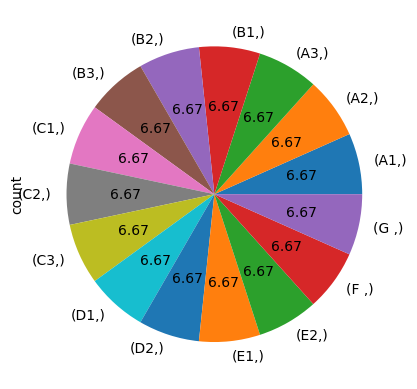

In [8]:
# check data to see if it is balanced
y_energy_rating_train_balanced.value_counts().plot.pie(autopct='%.2f')

### Pipeline for LightGBM

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from tfidf_transformer import TfidfTransformer

import lightgbm as lgb

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn import set_config

set_config(enable_metadata_routing=True) # required so that params can be passed to pipeline steps 

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(pd.DataFrame(X).head())
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# remove features to be dropped and set remainder='passthrough' to avoid errors in pipeline
def left_join_features(list_of_features_to_drop, num_cat_features):
    index_list = []
    for feature in list_of_features_to_drop:
        if feature in num_cat_features:
            index_list.append(num_cat_features.get_loc(feature))

    return num_cat_features.delete(index_list)

final_features_train = [] # placeholder
final_features_test = [] # placeholder

# pipeline 

def features_logging(df):
    print('features_logging 1: ', type(df))
    if isinstance(df, pd.DataFrame):
        print('features_logging 2: ', df.columns.values.tolist())    
        #print(df.head())
    print('feature logging 3: ', df.shape)
    return df

# function transformers
clean_up_features_transformer = FunctionTransformer(hf.clean_up_features)
drop_features_transformer = FunctionTransformer(hf.drop_features)
feature_main_heating_fuel_transformer = FunctionTransformer(hf.feature_main_heating_fuel)
feature_suspended_wooden_floor_transformer = FunctionTransformer(hf.feature_suspended_wooden_floor)
feature_ventilation_method_transformer = FunctionTransformer(hf.feature_ventilation_method)
features_convert_to_boolean = FunctionTransformer(hf.features_convert_to_boolean)
#feature_tf_idf = FunctionTransformer(hf.feature_tf_idf)
features_logging = FunctionTransformer(features_logging)


# numeric processing pipeline
numeric_processor = Pipeline(
    steps=[
            #('Imputation mean', SimpleImputer(missing_values=np.nan, strategy="median")),
            ('Scaler', MinMaxScaler()),
            #('Feature Logging - n 2', features_logging)
])

# categorical processing pipeline
category_processor = Pipeline(
    steps=[('feature_main_heating_fuel', feature_main_heating_fuel_transformer),
            ('feature_suspended_wooden_floor', feature_suspended_wooden_floor_transformer),
            ('feature_ventilation_method', feature_ventilation_method_transformer),
            ('features_convert_to_boolean', features_convert_to_boolean),
            ('feature_categorical_features_using_tf_idf', TfidfTransformer()),
            # ('feature_logging_c', features_logging)           
])

# determine categorical and numerical features
list_of_features_to_drop = hf.features_to_drop()

numerical_features = left_join_features(list_of_features_to_drop, X_train_balanced.select_dtypes(include=['int64', 'float64']).columns)
categorical_features = left_join_features(list_of_features_to_drop, X_train_balanced.select_dtypes(include=['object', 'bool']).columns)

print('pipeline features list: ', len(numerical_features), len(categorical_features))

# combining processing techniques
preprocessor = ColumnTransformer(
    [('categorical', category_processor, categorical_features),
     ('numerical', numeric_processor, numerical_features)]
)

#num_leaves=108, learning_rate=0.15, max_depth=30, n_estimators=200, reg_alpha=1, reg_lambda=1
param_initial = {
        'metric': 'rmse',
        #'boosting': 'dart', 
        #'random_state': 48,
        'n_estimators': 200,
        'num_leaves': 108, 
        'learning_rate': 0.15, 
        'max_depth': 35, 
        #'bagging_freq': 1, 
        'feature_fraction': 0.9,
        #'min_gain_to_split': 1,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01
}

params_classifier = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "n_estimators": 500,
    "verbosity": -1,
    "bagging_freq": 1
}

pipe1 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', drop_features_transformer),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging 3', features_logging),
            #('LightGBM', lgb.LGBMRegressor(**param_initial))
            ('LightGBM', lgb.LGBMClassifier(**params_classifier))
            #('LightGBM', lgb.LGBMClassifier())
            ])

pipeline features list:  141 50


In [28]:
pipe1

Pipeline(steps=[('Clean up features',
                 FunctionTransformer(func=<function clean_up_features at 0x0000016C3B1765C0>)),
                ('Drop features',
                 FunctionTransformer(func=<function drop_features at 0x0000016C51CB9800>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('feature_main_heating_fuel',
                                                                   FunctionTransformer(func=<function feature_mai...
       'SecondWallArea', 'SecondWallUValue', 'SecondWallAgeBandId',
       'SecondWallTypeId', 'ThirdWallArea', 'ThirdWallUValue',
       'ThirdWallAgeBandId', 'ThirdWallTypeId', 'prob_smarea_error_0corr',
       'prob_smarea_error_100corr'],
      dtype='object', length=141))])),
                ('LightGBM',
                 LGBMClassifier(bagging_freq=1, metric='multi_logloss',
                                n_estimators=500, objective='multiclass',
                                verbosity=-1))])

### Baseline for LightGBM

In [29]:
# fit, predict, metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report

print('X_train_balanced: ', type(X_train_balanced), X_train_balanced.shape)
print('y_energy_rating_train_balanced: ', type(y_energy_rating_train_balanced), y_energy_rating_train_balanced.shape)
print('X_test: ', type(X_test), X_test.shape)
print('y_energy_rating_test: ', type(y_energy_rating_test), y_energy_rating_test.shape)

pipe1.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score = pipe1.score(X_test, y_energy_rating_test)

y_preds = pipe1.predict(X_test)

# regression metrics
#print("R2: {:.3f}%".format(score*100) )
#print("Mean absolute error: " f"{mean_absolute_error(y_energy_rating_test, y_preds):.3f} kWh/m2/year")
#print("Median absolute error: " f"{median_absolute_error(y_energy_rating_test, y_preds):.3f} kWh/m2/year")
#print("Mean absolute percentage error: " f"{mean_absolute_percentage_error(y_energy_rating_test, y_preds) * 100:.3f} %")
#print("Mean squared error: " f"{mean_squared_error(y_energy_rating_test, y_preds, squared=False):.3f} %")

# classification metrics
report = classification_report(y_energy_rating_test, y_preds)
print(report)

X_train_balanced:  <class 'pandas.core.frame.DataFrame'> (86595, 210)
y_energy_rating_train_balanced:  <class 'pandas.core.frame.DataFrame'> (86595, 1)
X_test:  <class 'pandas.core.frame.DataFrame'> (22102, 210)
y_energy_rating_test:  <class 'pandas.core.frame.DataFrame'> (22102, 1)
drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (2

In [30]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_energy_rating_test, y_preds)
print(matrix)

[[1471   10    5    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  35 1336  108    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   2   50 1300  136    1    0    0    0    0    0    0    0    0    0
     0]
 [   2    0  111 1113  154    6    0    0    0    0    0    0    0    0
     0]
 [   0    0    3  194 1099  178    6    2    0    0    0    1    0    0
     0]
 [   0    0    1   11  241 1064  157   14    1    0    0    0    0    0
     0]
 [   0    0    0    0   14  339  835  273   30    2    2    1    0    0
     0]
 [   0    0    0    1    2   32  244  959  234   34    4    2    1    0
     0]
 [   0    0    0    1    3    1   16  352  699  327   28    3    0    0
     0]
 [   0    0    0    0    0    0    5   41  175  903  275   14    4    0
     0]
 [   0    0    0    0    0    0    3    3   17  193 1021  253   26    2
     0]
 [   0    0    0    0    0    0    0    5    1    8  181 1129  219   17
     0]
 [   0    0    0    0    0    0    0    

### Optuna for LightGBM

In [32]:
# optuna
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    
    global X_train_balanced, X_test, y_ber_rating_train_balanced, y_ber_rating_test

    # Define the parameter distributions for hyperparameter tuning
    # Using this guide: https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702
    # Parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters.html

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "n_estimators": 500,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.25, log=True), # Default is 0.1
        "num_leaves": trial.suggest_int("num_leaves", 8, 256), # Default is 31
        "max_depth": trial.suggest_int("max_depth", 10, 30),  # Default is -1
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 1, 100),  # Default is 20. AKA min_data_in_leaf.
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Default is 1. AKA bagging_fraction.
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),  # Default is 1.0. AKA colsample_bytree.
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1),  # Default is 0. AKA lambda_l1.
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1)  # Default is 0. AKA lambda_l2.
    }
    
    pipe2 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', drop_features_transformer),      
            ('preprocessor', preprocessor),
            ('LightGBM', lgb.LGBMClassifier(**params))
            ])

    pipe2.set_params(LightGBM__stopping_rounds=20).fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel()).score(X_test, y_energy_rating_test)
    preds = pipe2.predict(X_test)
    accuracy = accuracy_score(y_energy_rating_test, preds)
    
    return accuracy

In [33]:
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(study_name="lightGBM", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-04-02 22:36:25,851] A new study created in memory with name: lightGBM


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 22:53:33,510] Trial 0 finished with value: 0.7045516242873948 and parameters: {'learning_rate': 0.018973390366445814, 'num_leaves': 187, 'max_depth': 10, 'min_data_in_leaf': 31, 'subsample': 0.5733779454085566, 'feature_fraction': 0.5461692973843989, 'reg_alpha': 0.1943976092638942, 'reg_lambda': 0.35210511977261727}. Best is trial 0 with value: 0.7045516242873948.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 23:08:20,789] Trial 1 finished with value: 0.7095737942267668 and parameters: {'learning_rate': 0.01734761040654581, 'num_leaves': 142, 'max_depth': 18, 'min_data_in_leaf': 69, 'subsample': 0.6022261248657588, 'feature_fraction': 0.9390587181954727, 'reg_alpha': 0.0371137172659469, 'reg_lambda': 0.6737628350766182}. Best is trial 1 with value: 0.7095737942267668.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 23:25:01,483] Trial 2 finished with value: 0.7229210026241969 and parameters: {'learning_rate': 0.018997136585326296, 'num_leaves': 147, 'max_depth': 12, 'min_data_in_leaf': 20, 'subsample': 0.9003722843377684, 'feature_fraction': 0.9841307878596988, 'reg_alpha': 0.3202899363776504, 'reg_lambda': 0.6953993895126209}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 23:38:18,090] Trial 3 finished with value: 0.6887611980816216 and parameters: {'learning_rate': 0.14471247597908832, 'num_leaves': 230, 'max_depth': 11, 'min_data_in_leaf': 4, 'subsample': 0.5849152097822845, 'feature_fraction': 0.9390712517147066, 'reg_alpha': 0.10736336549471959, 'reg_lambda': 0.42689654875500166}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 23:51:45,341] Trial 4 finished with value: 0.7132838657135101 and parameters: {'learning_rate': 0.2075168796376781, 'num_leaves': 140, 'max_depth': 24, 'min_data_in_leaf': 32, 'subsample': 0.8432504638407918, 'feature_fraction': 0.9173128359486864, 'reg_alpha': 0.02810539457074989, 'reg_lambda': 0.7526428717955178}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-02 23:58:32,394] Trial 5 finished with value: 0.6527011130214461 and parameters: {'learning_rate': 0.23798203799201087, 'num_leaves': 194, 'max_depth': 15, 'min_data_in_leaf': 79, 'subsample': 0.551613003288821, 'feature_fraction': 0.7239467630879526, 'reg_alpha': 0.9095095480621646, 'reg_lambda': 0.30067800688994273}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 00:05:09,864] Trial 6 finished with value: 0.659759297801104 and parameters: {'learning_rate': 0.01071236894971911, 'num_leaves': 40, 'max_depth': 10, 'min_data_in_leaf': 68, 'subsample': 0.6058140580000295, 'feature_fraction': 0.6327733296861131, 'reg_alpha': 0.4966574276875349, 'reg_lambda': 0.06282891966590957}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 00:12:26,646] Trial 7 finished with value: 0.7193466654601394 and parameters: {'learning_rate': 0.038009934247071844, 'num_leaves': 44, 'max_depth': 22, 'min_data_in_leaf': 70, 'subsample': 0.5511672144139129, 'feature_fraction': 0.7070279939097841, 'reg_alpha': 0.6974561561504676, 'reg_lambda': 0.4200374768316336}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 00:25:52,525] Trial 8 finished with value: 0.6582209754773324 and parameters: {'learning_rate': 0.0037417330112370765, 'num_leaves': 141, 'max_depth': 23, 'min_data_in_leaf': 52, 'subsample': 0.9722973779954067, 'feature_fraction': 0.7932775202509965, 'reg_alpha': 0.9043678961350047, 'reg_lambda': 0.14609995710477516}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 00:41:16,298] Trial 9 finished with value: 0.679214550719392 and parameters: {'learning_rate': 0.005554511554181046, 'num_leaves': 209, 'max_depth': 18, 'min_data_in_leaf': 17, 'subsample': 0.963754290198017, 'feature_fraction': 0.6738829298727533, 'reg_alpha': 0.753303982104794, 'reg_lambda': 0.7287380054969469}. Best is trial 2 with value: 0.7229210026241969.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 00:52:05,970] Trial 10 finished with value: 0.7322414261152836 and parameters: {'learning_rate': 0.059223904085816535, 'num_leaves': 91, 'max_depth': 30, 'min_data_in_leaf': 99, 'subsample': 0.7859503048841812, 'feature_fraction': 0.8323364610397068, 'reg_alpha': 0.32775540054146657, 'reg_lambda': 0.9934564646405935}. Best is trial 10 with value: 0.7322414261152836.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:02:47,318] Trial 11 finished with value: 0.7299791874038548 and parameters: {'learning_rate': 0.058323047713704466, 'num_leaves': 87, 'max_depth': 30, 'min_data_in_leaf': 95, 'subsample': 0.7760892178389538, 'feature_fraction': 0.821630019321573, 'reg_alpha': 0.33939988078825145, 'reg_lambda': 0.9867037764310008}. Best is trial 10 with value: 0.7322414261152836.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:12:53,321] Trial 12 finished with value: 0.7286218441769976 and parameters: {'learning_rate': 0.06370546006501775, 'num_leaves': 85, 'max_depth': 30, 'min_data_in_leaf': 89, 'subsample': 0.7272378895280338, 'feature_fraction': 0.838876707414027, 'reg_alpha': 0.3863795030326116, 'reg_lambda': 0.9691004878001628}. Best is trial 10 with value: 0.7322414261152836.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:23:39,432] Trial 13 finished with value: 0.7241426115283685 and parameters: {'learning_rate': 0.07724484331308565, 'num_leaves': 90, 'max_depth': 30, 'min_data_in_leaf': 99, 'subsample': 0.7362484749795399, 'feature_fraction': 0.8190196514660516, 'reg_alpha': 0.28390074370166324, 'reg_lambda': 0.9967952662431866}. Best is trial 10 with value: 0.7322414261152836.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:34:10,878] Trial 14 finished with value: 0.7339607275359696 and parameters: {'learning_rate': 0.05281598396952281, 'num_leaves': 83, 'max_depth': 27, 'min_data_in_leaf': 99, 'subsample': 0.8192005973671506, 'feature_fraction': 0.8583868838117472, 'reg_alpha': 0.534982215734787, 'reg_lambda': 0.8688828361532135}. Best is trial 14 with value: 0.7339607275359696.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:40:03,479] Trial 15 finished with value: 0.7334630350194552 and parameters: {'learning_rate': 0.11226050217459266, 'num_leaves': 17, 'max_depth': 26, 'min_data_in_leaf': 83, 'subsample': 0.8079451728041316, 'feature_fraction': 0.8866135700601754, 'reg_alpha': 0.5753761802411066, 'reg_lambda': 0.852975916273148}. Best is trial 14 with value: 0.7339607275359696.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:44:29,457] Trial 16 finished with value: 0.7136458239073387 and parameters: {'learning_rate': 0.12323658534241538, 'num_leaves': 9, 'max_depth': 26, 'min_data_in_leaf': 54, 'subsample': 0.6768818983425196, 'feature_fraction': 0.9043483478189728, 'reg_alpha': 0.6192315982639698, 'reg_lambda': 0.8460743628478027}. Best is trial 14 with value: 0.7339607275359696.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:50:44,214] Trial 17 finished with value: 0.6876753235001357 and parameters: {'learning_rate': 0.03321491923503595, 'num_leaves': 16, 'max_depth': 26, 'min_data_in_leaf': 82, 'subsample': 0.8544997614621959, 'feature_fraction': 0.8770667002225729, 'reg_alpha': 0.5259015817411488, 'reg_lambda': 0.5744587157064143}. Best is trial 14 with value: 0.7339607275359696.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 01:59:10,240] Trial 18 finished with value: 0.73744457515157 and parameters: {'learning_rate': 0.10448682563835779, 'num_leaves': 54, 'max_depth': 27, 'min_data_in_leaf': 81, 'subsample': 0.84496153697656, 'feature_fraction': 0.7671699107546466, 'reg_alpha': 0.7710123930667038, 'reg_lambda': 0.8502940751146796}. Best is trial 18 with value: 0.73744457515157.


drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)


[I 2024-04-03 02:08:24,925] Trial 19 finished with value: 0.7384852049588273 and parameters: {'learning_rate': 0.03853760378058098, 'num_leaves': 59, 'max_depth': 27, 'min_data_in_leaf': 63, 'subsample': 0.8950210378605308, 'feature_fraction': 0.7545552753895864, 'reg_alpha': 0.7820124418196901, 'reg_lambda': 0.5481419089874953}. Best is trial 19 with value: 0.7384852049588273.


Number of finished trials: 20
Best trial: {'learning_rate': 0.03853760378058098, 'num_leaves': 59, 'max_depth': 27, 'min_data_in_leaf': 63, 'subsample': 0.8950210378605308, 'feature_fraction': 0.7545552753895864, 'reg_alpha': 0.7820124418196901, 'reg_lambda': 0.5481419089874953}


In [34]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.704552,2024-04-02 22:36:25.865980,2024-04-02 22:53:33.502637,0 days 00:17:07.636657,0.546169,0.018973,10,31,187,0.194398,0.352105,0.573378,COMPLETE
1,1,0.709574,2024-04-02 22:53:33.524640,2024-04-02 23:08:20.785677,0 days 00:14:47.261037,0.939059,0.017348,18,69,142,0.037114,0.673763,0.602226,COMPLETE
2,2,0.722921,2024-04-02 23:08:20.799823,2024-04-02 23:25:01.478108,0 days 00:16:40.678285,0.984131,0.018997,12,20,147,0.320290,0.695399,0.900372,COMPLETE
3,3,0.688761,2024-04-02 23:25:01.492109,2024-04-02 23:38:18.085035,0 days 00:13:16.592926,0.939071,0.144712,11,4,230,0.107363,0.426897,0.584915,COMPLETE
4,4,0.713284,2024-04-02 23:38:18.099047,2024-04-02 23:51:45.337202,0 days 00:13:27.238155,0.917313,0.207517,24,32,140,0.028105,0.752643,0.843250,COMPLETE
5,5,0.652701,2024-04-02 23:51:45.352205,2024-04-02 23:58:32.390000,0 days 00:06:47.037795,0.723947,0.237982,15,79,194,0.909510,0.300678,0.551613,COMPLETE
6,6,0.659759,2024-04-02 23:58:32.403012,2024-04-03 00:05:09.860354,0 days 00:06:37.457342,0.632773,0.010712,10,68,40,0.496657,0.062829,0.605814,COMPLETE
7,7,0.719347,2024-04-03 00:05:09.874327,2024-04-03 00:12:26.640152,0 days 00:07:16.765825,0.707028,0.038010,22,70,44,0.697456,0.420037,0.551167,COMPLETE
8,8,0.658221,2024-04-03 00:12:26.659156,2024-04-03 00:25:52.519636,0 days 00:13:25.860480,0.793278,0.003742,23,52,141,0.904368,0.146100,0.972297,COMPLETE
9,9,0.679215,2024-04-03 00:25:52.536629,2024-04-03 00:41:16.295307,0 days 00:15:23.758678,0.673883,0.005555,18,17,209,0.753304,0.728738,0.963754,COMPLETE


In [36]:
print('Best hyperparameters:', study.best_params)
print('Best multi_logloss:', study.best_value)

Best hyperparameters: {'learning_rate': 0.03853760378058098, 'num_leaves': 59, 'max_depth': 27, 'min_data_in_leaf': 63, 'subsample': 0.8950210378605308, 'feature_fraction': 0.7545552753895864, 'reg_alpha': 0.7820124418196901, 'reg_lambda': 0.5481419089874953}
Best multi_logloss: 0.7384852049588273


### Results for LightGBM Classifier using optimised parameters from Optuna

In [37]:
# Best parms - copied from above
#best_params = {'learning_rate': 0.13878295273718808, 'num_leaves': 230, 'max_depth': 29, 'min_data_in_leaf': 56, 'subsample': 0.5324168009765406, 'feature_fraction': 0.8470566171420315, 'reg_alpha': 0.9819147551958919, 'reg_lambda': 0.575487906743726}
#best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1, 'learning_rate': 0.03853760378058098, 'num_leaves': 59, 'max_depth': 27, 'min_data_in_leaf': 63, 'subsample': 0.8950210378605308, 'feature_fraction': 0.7545552753895864, 'reg_alpha': 0.7820124418196901, 'reg_lambda': 0.5481419089874953}

pipe3 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', drop_features_transformer),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('LightGBM', lgb.LGBMClassifier(**best_params))
            ])

pipe3.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_3 = pipe3.score(X_test, y_energy_rating_test)

y_preds_3 = pipe3.predict(X_test)

# metrics
#print("R2: {:.3f}%".format(score*100) )
#print("Mean absolute error: " f"{mean_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Median absolute error: " f"{median_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Mean absolute percentage error: " f"{mean_absolute_percentage_error(y_ber_rating_test, y_preds_3) * 100:.3f} %")
#print("RMSE (mean squared error): " f"{mean_squared_error(y_ber_rating_test, y_preds_3, squared=False):.3f} %")

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_3)
print(report)

drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
              precision    recall  f1-score   support

          A1       0.97      0.99      0.98      1486
          A2       0.95      0.90      0.92      1479
          A3       0.85      0.85      0.85      1489
          B1       0.74      0.79      0.76      1386
   

### Comparison with HistGradientBoostingClassifier

In [38]:
# Build HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

# Best parms - copied from above
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}


pipe4 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', drop_features_transformer),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('HGBR', HistGradientBoostingClassifier())
            ])

pipe4.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_4 = pipe4.score(X_test, y_energy_rating_test)

y_preds_4 = pipe4.predict(X_test)

# metrics
#print("R2: {:.3f}%".format(score*100) )
#print("Mean absolute error: " f"{mean_absolute_error(y_ber_rating_test, y_preds_4):.3f} kWh/m2/year")
#print("Median absolute error: " f"{median_absolute_error(y_ber_rating_test, y_preds_4):.3f} kWh/m2/year")
#print("Mean absolute percentage error: " f"{mean_absolute_percentage_error(y_ber_rating_test, y_preds_4) * 100:.3f} %")
#print("RMSE (mean squared error): " f"{mean_squared_error(y_ber_rating_test, y_preds_4, squared=False):.3f} %")

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_4)
print(report)

drop_features end:  (86595, 191)
boolean_cols end: (86595, 49)
TfidfTransformer - fit
TfidfTransformer - transform
start: (86595, 49)
train - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (86595, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
drop_features end:  (22102, 191)
boolean_cols end: (22102, 49)
TfidfTransformer - transform
start: (22102, 49)
test - tf_idf_all_column_names_train_keep: 19
TfIdfTransformer fit end:  <class 'pandas.core.frame.DataFrame'> (22102, 38)
              precision    recall  f1-score   support

          A1       0.97      0.98      0.98      1486
          A2       0.94      0.88      0.91      1479
          A3       0.80      0.83      0.82      1489
          B1       0.68      0.74      0.71      1386
   